Using device: cuda
Loaded base SudokuMDM model.
Loading Sudoku from CSV: ./data/sudoku.csv


/home/jaisharma/miniconda3/envs/sudoku/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Loaded 10000 puzzles from CSV
Training Neural Estimator...


Epoch 5/5: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=0.0513] 



--- Starting Comparison Evaluation ---
Testing on 100 puzzles with 90% masking.

Evaluating Step Size k=1...
  Random Acc: 100.00%
  Confidence Acc: 100.00%
  MI-Guided Acc: 100.00%

Evaluating Step Size k=4...
  Random Acc: 100.00%
  Confidence Acc: 100.00%
  MI-Guided Acc: 100.00%

Evaluating Step Size k=8...
  Random Acc: 100.00%
  Confidence Acc: 100.00%
  MI-Guided Acc: 100.00%

Evaluating Step Size k=16...
  Random Acc: 100.00%
  Confidence Acc: 100.00%
  MI-Guided Acc: 100.00%


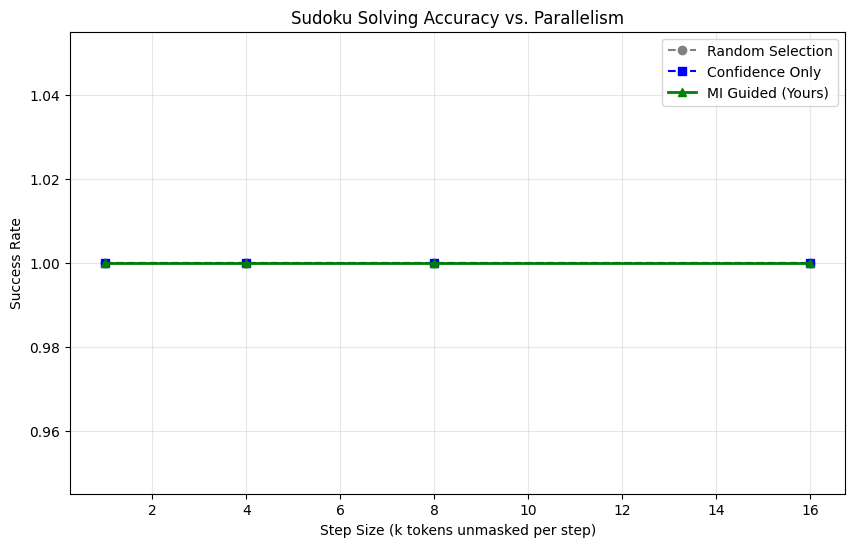

Done! Check sudoku_results.png


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from tqdm import tqdm

# --- 1. Setup & Imports ---
sys.path.append('.')
# Assuming sudoku.py is in the directory as per your previous code
from sudoku2 import (
    SudokuDataset, SudokuMDM, MaskSchedule, check_sudoku_valid
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- 2. Load Base Model (Frozen) ---
def load_base_model():
    model_config = {
        'vocab_size': 10,
        'd_model': 384,
        'nhead': 12,
        'num_layers': 4,
        'dim_feedforward': 512,
        'dropout': 0.1,
        'max_seq_len': 81
    }
    model = SudokuMDM(**model_config).to(device)
    # Load your checkpoint
    try:
        checkpoint = torch.load('./checkpoints/sudoku_mdm_best.pt', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded base SudokuMDM model.")
    except FileNotFoundError:
        print("Error: Base model checkpoint not found. Please check path.")
        sys.exit(1)
        
    model.eval()
    return model

base_model = load_base_model()

# --- 3. Improved CE Predictor Model ---
class OptimizedCEPredictor(nn.Module):
    """
    Predicts H(j | i, c). 
    Uses a small Transformer adapter to process frozen embeddings before pairwise interaction.
    """
    def __init__(self, mdm_model, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.mdm_dim = mdm_model.d_model
        
        # We don't register mdm_model as a submodule to avoid saving it twice, 
        # but we need access to its embedding layers. 
        # We assume the external training loop handles the frozen MDM data flow.
        
        # Adapter: Refines embeddings specifically for Entropy prediction
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=4, dim_feedforward=256, 
            dropout=dropout, batch_first=True
        )
        self.adapter = nn.Sequential(
            nn.Linear(self.mdm_dim, hidden_dim),
            nn.GELU(),
            nn.TransformerEncoder(encoder_layer, num_layers=1)
        )
        
        # Bilinear Pairwise Head
        self.query_proj = nn.Linear(hidden_dim, hidden_dim) # Source (i)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)   # Target (j)
        
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.GELU(),
            nn.Linear(64, 1),
            nn.Softplus() # Entropy must be positive
        )

    def forward(self, mdm_embeddings):
        # mdm_embeddings: [B, 81, mdm_dim] (Frozen features from base model)
        
        h = self.adapter(mdm_embeddings) # [B, 81, H]
        
        q = self.query_proj(h) # [B, 81, H]
        k = self.key_proj(h)   # [B, 81, H]
        
        # Interaction: (B, 81, 1, H) * (B, 1, 81, H) -> (B, 81, 81, H)
        interaction = q.unsqueeze(2) * k.unsqueeze(1)
        
        out = self.output_head(interaction).squeeze(-1) # [B, 81, 81]
        return out

# --- 4. Fast Vectorized Ground Truth Generation ---
def get_sparse_ce_targets(model, puzzles, num_pairs=64, k=5):
    """
    Computes ground truth H(j|i) for random pairs efficiently using batched inference.
    """
    B = puzzles.shape[0]
    
    # 1. Get Base Probabilities
    with torch.no_grad():
        base_logits = model(puzzles)
        base_probs = F.softmax(base_logits, dim=-1) # [B, 81, 10]
        
    # 2. Select Random Pairs (i, j) where puzzle is masked
    queries = [] 
    is_masked = (puzzles == 0)
    
    for b in range(B):
        masked_indices = is_masked[b].nonzero(as_tuple=True)[0]
        if len(masked_indices) < 2: continue
        
        # Pick random pairs
        idxs = torch.randint(0, len(masked_indices), (num_pairs, 2), device=device)
        srcs = masked_indices[idxs[:, 0]]
        tgts = masked_indices[idxs[:, 1]]
        
        # Filter i == j
        valid = (srcs != tgts)
        for i, j in zip(srcs[valid], tgts[valid]):
            queries.append((b, i.item(), j.item()))
            
    if not queries:
        return None, None

    # 3. Build Batch of Hypothetical Puzzles
    # We want to calculate H(j | X_i = v)
    unique_sources = {} # (b, i) -> list of j targets
    for b, i, j in queries:
        if (b, i) not in unique_sources: unique_sources[(b, i)] = []
        unique_sources[(b, i)].append(j)
        
    hypo_puzzles = []
    meta = []
    
    for (b, i), target_list in unique_sources.items():
        # Get top-k tokens for position i
        probs_i = base_probs[b, i, 1:] # Skip mask
        top_p, top_idx = torch.topk(probs_i, k)
        top_idx = top_idx + 1 # Adjust to 1-9 range
        weights = top_p / top_p.sum()
        
        for idx in range(len(top_idx)):
            token = top_idx[idx]
            w = weights[idx]
            
            p_new = puzzles[b].clone()
            p_new[i] = token
            hypo_puzzles.append(p_new)
            meta.append({'b': b, 'i': i, 'w': w, 'targets': target_list})

    # 4. Run Massive Inference
    if not hypo_puzzles: return None, None
    
    hypo_batch = torch.stack(hypo_puzzles)
    
    # Process in chunks to save VRAM
    results = {} # (b, i, j) -> accum_entropy
    chunk_size = 256
    
    with torch.no_grad():
        for start in range(0, len(hypo_batch), chunk_size):
            end = min(start + chunk_size, len(hypo_batch))
            batch_slice = hypo_batch[start:end]
            
            logits = model(batch_slice)
            probs = F.softmax(logits, dim=-1)
            # Calculate Entropy Map: [Batch, 81]
            H_map = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            for local_idx in range(end - start):
                m = meta[start + local_idx]
                h_vals = H_map[local_idx]
                
                for j in m['targets']:
                    key = (m['b'], m['i'], j)
                    if key not in results: results[key] = 0.0
                    results[key] += m['w'].item() * h_vals[j].item()

    # 5. Assemble Tensors
    indices = torch.tensor(queries, dtype=torch.long, device=device)
    target_values = torch.tensor([results[q] for q in queries], dtype=torch.float, device=device)
    
    return indices, target_values

# --- 5. Train the CE Predictor ---
def train_ce_predictor(base_model, dataset, epochs=5):
    predictor = OptimizedCEPredictor(base_model).to(device)
    optimizer = torch.optim.AdamW(predictor.parameters(), lr=3e-4)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    mask_sched = MaskSchedule(schedule_type='linear', total_steps=40)
    
    print("Training Neural Estimator...")
    predictor.train()
    
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for _, solutions in pbar:
            solutions = solutions.to(device)
            # Create random masks
            puzzles = solutions.clone()
            t = np.random.randint(1, 40) # Random difficulty
            ratio = mask_sched.get_mask_ratio(t)
            puzzles, _ = mask_sched.apply_mask(puzzles, ratio)
            
            # 1. Get Ground Truth
            indices, targets = get_sparse_ce_targets(base_model, puzzles, k=5)
            if indices is None: continue
            
            # 2. Forward Pass
            # Get embeddings from frozen base model first
            with torch.no_grad():
                emb = base_model.embedding(puzzles)
                emb = base_model.pos_encoder(emb)
                features = base_model.transformer(emb)
            
            # Predict
            pred_matrix = predictor(features)
            
            # 3. Loss
            # Gather predictions for the specific pairs we calculated
            preds = pred_matrix[indices[:,0], indices[:,1], indices[:,2]]
            loss = F.mse_loss(preds, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
    return predictor

# --- 6. Solvers ---

def solve_random(model, puzzle, k=5, max_steps=100):
    """Baseline: Picks k random empty cells per step."""
    curr = puzzle.clone()
    
    # Loop until board is full or we hit max_steps
    for step in range(max_steps):
        mask = (curr == 0)
        if not mask.any(): break
            
        with torch.no_grad():
            logits = model(curr)
            preds = torch.argmax(logits, dim=-1)
            
        for b in range(curr.shape[0]):
            indices = mask[b].nonzero(as_tuple=True)[0]
            if len(indices) == 0: continue
            
            # Select k random indices
            perm = torch.randperm(len(indices))
            selected = indices[perm[:k]]
            
            curr[b, selected] = preds[b, selected]
            
    return curr

def solve_confidence(model, puzzle, k=5, max_steps=100):
    """Baseline: Picks k lowest entropy cells."""
    curr = puzzle.clone()
    
    for step in range(max_steps):
        mask = (curr == 0)
        if not mask.any(): break
        
        with torch.no_grad():
            logits = model(curr)
            probs = F.softmax(logits, dim=-1)
            # Calculate Entropy H(i)
            H = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            H[~mask] = float('inf') # Ignore already filled
            
            preds = torch.argmax(logits, dim=-1)
            
        for b in range(curr.shape[0]):
            # Get top k smallest entropy (most confident)
            num_masked = mask[b].sum()
            if num_masked == 0: continue
            
            actual_k = min(k, num_masked)
            vals, indices = torch.topk(H[b], k=actual_k, largest=False)
            curr[b, indices] = preds[b, indices]
            
    return curr

def solve_mi_guided(model, ce_predictor, puzzle, k=5, max_steps=100, penalty=2.0):
    """Your Method: Picks k cells minimizing (Entropy + Penalty * Redundancy)."""
    curr = puzzle.clone()
    ce_predictor.eval()
    
    for step in range(max_steps):
        mask = (curr == 0)
        if not mask.any(): break
        
        with torch.no_grad():
            # Base Model Features
            emb = model.embedding(curr)
            emb = model.pos_encoder(emb)
            features = model.transformer(emb)
            logits = model.fc_out(features)
            
            probs = F.softmax(logits, dim=-1)
            H_i = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1) # [B, 81]
            
            # Predict Conditional Entropy
            H_j_given_i = ce_predictor(features) # [B, 81, 81]
            
            # MI(i, j) = H(j) - H(j|i)
            MI = H_i.unsqueeze(1) - H_j_given_i
            MI = torch.clamp(MI, min=0)
            MI = (MI + MI.transpose(1, 2)) / 2 # Symmetrize
            
            preds = torch.argmax(logits, dim=-1)
        
        # Greedy Selection Loop
        for b in range(curr.shape[0]):
            candidates = mask[b].nonzero(as_tuple=True)[0].tolist()
            if not candidates: continue
            
            selected = []
            target_k = min(k, len(candidates))
            local_H = H_i[b]
            local_MI = MI[b]
            remaining = set(candidates)
            
            for _ in range(target_k):
                best_score = float('inf')
                best_idx = -1
                
                for idx in remaining:
                    base_score = local_H[idx].item()
                    redundancy = 0.0
                    if selected:
                        redundancy = local_MI[idx, selected].max().item()
                    
                    # Score = Confidence + Independence
                    score = base_score + (penalty * redundancy)
                    
                    if score < best_score:
                        best_score = score
                        best_idx = idx
                
                if best_idx != -1:
                    selected.append(best_idx)
                    remaining.remove(best_idx)
            
            for idx in selected:
                curr[b, idx] = preds[b, idx]
                
    return curr

# --- 7. Main Execution Block ---

# A. Train (Quickly)
# Load a smaller subset for quick demo if needed, or full dataset
full_dataset = SudokuDataset('./data/sudoku.csv') 
# Use a subset to train faster for this demo
train_size = 2000
subset_indices = list(range(train_size))
train_set = torch.utils.data.Subset(full_dataset, subset_indices)

ce_predictor = train_ce_predictor(base_model, train_set, epochs=5)

# B. Evaluation
print("\n--- Starting Comparison Evaluation ---")

# Ensure validation set is distinct
# (Assuming the dataset loaded 10000 samples)
eval_size = 100
start_idx = 2000 # Past the training set we used
val_indices = list(range(start_idx, start_idx + eval_size))

# Extract puzzles
val_puzzles = torch.stack([full_dataset[i][1] for i in val_indices]).to(device)

# --- INCREASE DIFFICULTY ---
# Mask 90% of the board (very sparse start)
mask_sched = MaskSchedule('linear', 40)
# Use a high mask ratio (0.9) to make the model struggle more
puzzles_masked, _ = mask_sched.apply_mask(val_puzzles, 0.9)

print(f"Testing on {eval_size} puzzles with 90% masking.")

k_values = [1, 4, 8, 16] 
results = {'Random': [], 'Confidence': [], 'MI-Guided': []}

for k in k_values:
    print(f"\nEvaluating Step Size k={k}...")
    
    # 1. Random
    res_rnd = solve_random(base_model, puzzles_masked, k=k)
    # Check if board is full (no zeros) AND valid
    acc_rnd = [check_sudoku_valid(p) for p in res_rnd]
    acc_rnd = sum(acc_rnd) / len(acc_rnd)
    results['Random'].append(acc_rnd)
    print(f"  Random Acc: {acc_rnd:.2%}")
    
    # 2. Confidence
    res_conf = solve_confidence(base_model, puzzles_masked, k=k)
    acc_conf = [check_sudoku_valid(p) for p in res_conf]
    acc_conf = sum(acc_conf) / len(acc_conf)
    results['Confidence'].append(acc_conf)
    print(f"  Confidence Acc: {acc_conf:.2%}")
    
    # 3. MI Guided
    res_mi = solve_mi_guided(base_model, ce_predictor, puzzles_masked, k=k)
    acc_mi = [check_sudoku_valid(p) for p in res_mi]
    acc_mi = sum(acc_mi) / len(acc_mi)
    results['MI-Guided'].append(acc_mi)
    print(f"  MI-Guided Acc: {acc_mi:.2%}")

# --- 8. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, results['Random'], 'o--', label='Random Selection', color='gray')
plt.plot(k_values, results['Confidence'], 's--', label='Confidence Only', color='blue')
plt.plot(k_values, results['MI-Guided'], '^-', label='MI Guided (Yours)', color='green', linewidth=2)

plt.xlabel('Step Size (k tokens unmasked per step)')
plt.ylabel('Success Rate')
plt.title('Sudoku Solving Accuracy vs. Parallelism')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sudoku_results.png')
plt.show()

print("Done! Check sudoku_results.png")

In [3]:
# ============================================================================
# 8. Comparison with Debugging & Empty Grid Generation
# ============================================================================

def solve_with_logging(model, ce_predictor, puzzle, strategy='random', k=5, max_steps=100, penalty=2.0):
    """
    Solves puzzle and returns (solved_puzzle, logs)
    logs contains 'avg_entropy' per step to see if the model is actually challenged.
    """
    curr = puzzle.clone()
    logs = {'entropy': []}
    
    ce_predictor.eval() if ce_predictor else None
    
    for step in range(max_steps):
        mask = (curr == 0)
        if not mask.any(): break
        
        with torch.no_grad():
            # Get model predictions
            # We want to access the internal features if using MI, so we might duplicate work slightly
            # or just run the forward pass once.
            emb = model.embedding(curr)
            emb = model.pos_encoder(emb)
            features = model.transformer(emb)
            logits = model.fc_out(features)
            
            probs = F.softmax(logits, dim=-1)
            H_i = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1) # [B, 81]
            H_i[~mask] = float('inf') # Ignore filled
            
            preds = torch.argmax(logits, dim=-1)

        # Logging: Track how "confused" the model is on the candidate cells
        # We only care about entropy of the MASKED cells
        masked_entropy = H_i.clone()
        masked_entropy[~mask] = 0
        avg_entropy = masked_entropy.sum() / (mask.sum() + 1e-9)
        logs['entropy'].append(avg_entropy.item())

        # Selection Logic
        for b in range(curr.shape[0]):
            candidates = mask[b].nonzero(as_tuple=True)[0].tolist()
            if not candidates: continue
            
            # 1. Determine Selection
            selected = []
            target_k = min(k, len(candidates))
            
            if strategy == 'random':
                perm = torch.randperm(len(candidates))
                selected = [candidates[i] for i in perm[:target_k]]
                
            elif strategy == 'confidence':
                # Pick lowest entropy
                local_H = H_i[b]
                # vals, indices from the *original* 81 size
                # We can just topk on the whole row since filled are inf
                _, topk_indices = torch.topk(local_H, k=target_k, largest=False)
                selected = topk_indices.tolist()

            elif strategy == 'mi':
                # Re-run predictor for this batch item (optimized)
                # Note: For speed in this loop, we did the forward pass outside.
                # We need H(j|i) now.
                with torch.no_grad():
                     H_j_given_i = ce_predictor(features) # [B, 81, 81]
                
                # MI Matrix
                local_H = H_i[b]
                local_H_j_given_i = H_j_given_i[b]
                
                # MI = H(j) - H(j|i)
                # Careful: H(j) must use the same distribution as H(j|i) implies? 
                # Ideally yes, but using the base model's H(j) is the standard approximation.
                
                local_MI = local_H.unsqueeze(0) - local_H_j_given_i
                local_MI = torch.clamp(local_MI, min=0)
                local_MI = (local_MI + local_MI.T) / 2
                
                remaining = set(candidates)
                
                for _ in range(target_k):
                    best_score = float('inf')
                    best_idx = -1
                    
                    for idx in remaining:
                        base_score = local_H[idx].item()
                        redundancy = 0.0
                        if selected:
                            redundancy = local_MI[idx, selected].max().item()
                        
                        score = base_score + (penalty * redundancy)
                        if score < best_score:
                            best_score = score
                            best_idx = idx
                            
                    if best_idx != -1:
                        selected.append(best_idx)
                        remaining.remove(best_idx)

            # 2. Update Grid
            for idx in selected:
                curr[b, idx] = preds[b, idx]
                
    return curr, logs

# --- RUN EVALUATION ---

print("\n--- Starting Evaluation: Pure Generation (Empty Grid) ---")
# This is the hardest test: Generate valid Sudokus from scratch.
# If Random gets 100% here, your model is truly overfitted/memorizing.

num_eval = 50
# Create completely empty grids
empty_puzzles = torch.zeros((num_eval, 81), dtype=torch.long, device=device)

k_values = [4, 8, 16] 

for k in k_values:
    print(f"\n[Step Size k={k}]")
    
    # 1. Random
    res_rnd, log_rnd = solve_with_logging(base_model, None, empty_puzzles, 'random', k=k)
    acc_rnd = sum([check_sudoku_valid(p) for p in res_rnd]) / num_eval
    ent_rnd = sum(log_rnd['entropy']) / len(log_rnd['entropy'])
    print(f"  Random     | Acc: {acc_rnd:.2%} | Avg Entropy: {ent_rnd:.4f}")
    
    # 2. Confidence
    res_conf, log_conf = solve_with_logging(base_model, None, empty_puzzles, 'confidence', k=k)
    acc_conf = sum([check_sudoku_valid(p) for p in res_conf]) / num_eval
    ent_conf = sum(log_conf['entropy']) / len(log_conf['entropy'])
    print(f"  Confidence | Acc: {acc_conf:.2%} | Avg Entropy: {ent_conf:.4f}")
    
    # 3. MI Guided
    res_mi, log_mi = solve_with_logging(base_model, ce_predictor, empty_puzzles, 'mi', k=k)
    acc_mi = sum([check_sudoku_valid(p) for p in res_mi]) / num_eval
    ent_mi = sum(log_mi['entropy']) / len(log_mi['entropy'])
    print(f"  MI-Guided  | Acc: {acc_mi:.2%} | Avg Entropy: {ent_mi:.4f}")
    
    if acc_rnd == 1.0 and acc_mi == 1.0:
        print("  [DEBUG] Model is too certain. Entropy is likely near 0.")


--- Starting Evaluation: Pure Generation (Empty Grid) ---

[Step Size k=4]
  Random     | Acc: 100.00% | Avg Entropy: 1.0133
  Confidence | Acc: 100.00% | Avg Entropy: 1.5302
  MI-Guided  | Acc: 100.00% | Avg Entropy: 1.5184
  [DEBUG] Model is too certain. Entropy is likely near 0.

[Step Size k=8]
  Random     | Acc: 100.00% | Avg Entropy: 1.1195
  Confidence | Acc: 100.00% | Avg Entropy: 1.5535
  MI-Guided  | Acc: 100.00% | Avg Entropy: 1.5926
  [DEBUG] Model is too certain. Entropy is likely near 0.

[Step Size k=16]
  Random     | Acc: 100.00% | Avg Entropy: 1.2601
  Confidence | Acc: 100.00% | Avg Entropy: 1.7720
  MI-Guided  | Acc: 100.00% | Avg Entropy: 1.7081
  [DEBUG] Model is too certain. Entropy is likely near 0.



  EVALUATION: PARALLEL SAMPLING (T=1.0)
  Hypothesis: MI-Guided should avoid conflicts better than Random

[Step Size k=1]
  Random     | Valid: 100% | Unique: 50/50
  Confidence | Valid: 100% | Unique: 50/50
  MI-Guided  | Valid: 100% | Unique: 50/50

[Step Size k=8]
  Random     | Valid: 100% | Unique: 50/50
  Confidence | Valid: 100% | Unique: 50/50
  MI-Guided  | Valid: 100% | Unique: 50/50

[Step Size k=16]
  Random     | Valid: 100% | Unique: 50/50
  Confidence | Valid: 100% | Unique: 50/50
  MI-Guided  | Valid: 100% | Unique: 50/50

[Step Size k=32]
  Random     | Valid: 100% | Unique: 50/50
  Confidence | Valid: 100% | Unique: 50/50
  MI-Guided  | Valid: 100% | Unique: 50/50


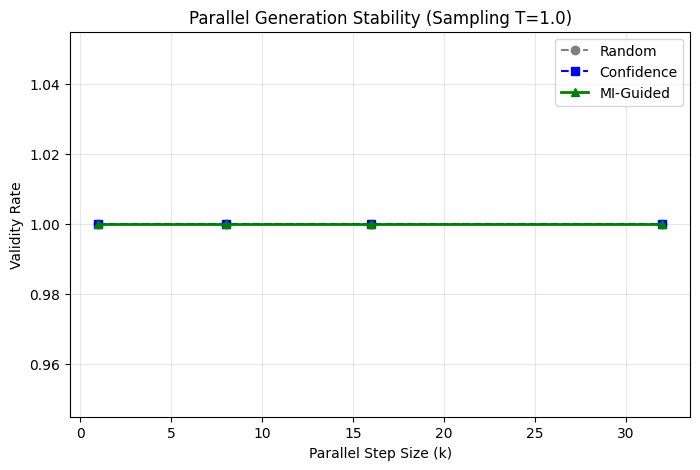

In [8]:
def solve_sampling(model, ce_predictor, puzzle, strategy='random', k=5, max_steps=100, penalty=3.0, temperature=1.0):
    """
    Solves using SAMPLING instead of Argmax to force diversity and expose conflicts.
    """
    curr = puzzle.clone()
    ce_predictor.eval() if ce_predictor else None
    
    for step in range(max_steps):
        mask = (curr == 0)
        if not mask.any(): break
        
        with torch.no_grad():
            # 1. Forward Pass
            emb = model.embedding(curr)
            emb = model.pos_encoder(emb)
            features = model.transformer(emb)
            logits = model.fc_out(features)
            
            # Apply Temperature
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            
            # Entropy for selection (using T=1.0 for selection metric usually stable)
            # We use the 'probs' derived from T for selection to match the sampling risk
            H_i = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            H_i[~mask] = float('inf')
            
            # --- CRITICAL CHANGE: SAMPLE INSTEAD OF ARGMAX ---
            # We sample from the distribution for every cell
            # shape: [B, 81]
            dist = torch.distributions.Categorical(probs)
            sampled_tokens = dist.sample()
            # sampled_tokens = torch.argmax(probs, dim=-1)

        # 2. Selection Logic (Same as before)
        # We need to decide WHICH of these sampled tokens to actually keep
        for b in range(curr.shape[0]):
            candidates = mask[b].nonzero(as_tuple=True)[0].tolist()
            if not candidates: continue
            
            selected = []
            target_k = min(k, len(candidates))
            
            if strategy == 'random':
                perm = torch.randperm(len(candidates))
                selected = [candidates[i] for i in perm[:target_k]]
                
            elif strategy == 'confidence':
                # Pick lowest entropy
                local_H = H_i[b]
                _, topk_indices = torch.topk(local_H, k=target_k, largest=False)
                selected = topk_indices.tolist()

            elif strategy == 'mi':
                with torch.no_grad():
                     H_j_given_i = ce_predictor(features)
                
                local_H = H_i[b]
                local_H_j_given_i = H_j_given_i[b]
                
                # MI Calculation
                local_MI = local_H.unsqueeze(0) - local_H_j_given_i
                local_MI = torch.clamp(local_MI, min=0)
                local_MI = (local_MI + local_MI.T) / 2
                
                remaining = set(candidates)
                
                for _ in range(target_k):
                    best_score = float('inf')
                    best_idx = -1
                    
                    for idx in remaining:
                        base_score = local_H[idx].item()
                        redundancy = 0.0
                        if selected:
                            redundancy = local_MI[idx, selected].max().item()
                        
                        # We penalize redundancy heavily to ensure safety
                        score = base_score + (penalty * redundancy)
                        if score < best_score:
                            best_score = score
                            best_idx = idx
                            
                    if best_idx != -1:
                        selected.append(best_idx)
                        remaining.remove(best_idx)

            # 3. Update Grid with SAMPLED tokens
            # This is where conflicts happen if 'selected' indices are correlated
            for idx in selected:
                curr[b, idx] = sampled_tokens[b, idx]
                
    return curr

# --- RUN EVALUATION (SAMPLING MODE) ---
print("\n" + "="*50)
print("  EVALUATION: PARALLEL SAMPLING (T=1.0)")
print("  Hypothesis: MI-Guided should avoid conflicts better than Random")
print("="*50)

# Generate 50 puzzles from scratch
num_eval = 50
empty_puzzles = torch.zeros((num_eval, 81), dtype=torch.long, device=device)

# We expect k=1 to work for all (serial generation)
# We expect k=16 to FAIL for Random (conflicts) but WORK for MI
k_values = [1, 8, 16, 32] 

# Helper to check uniqueness (detect memorization)
def count_unique(puzzles):
    # Convert to string to hash
    uniques = set()
    for p in puzzles:
        s = "".join(map(str, p.cpu().numpy()))
        uniques.add(s)
    return len(uniques)

results_data = {'k': k_values, 'Random': [], 'Confidence': [], 'MI': []}

for k in k_values:
    print(f"\n[Step Size k={k}]")
    
    # 1. Random
    res_rnd = solve_sampling(base_model, None, empty_puzzles, 'random', k=k, temperature=1.0)
    acc_rnd = sum([check_sudoku_valid(p) for p in res_rnd]) / num_eval
    uniq_rnd = count_unique(res_rnd)
    print(f"  Random     | Valid: {acc_rnd:.0%} | Unique: {uniq_rnd}/{num_eval}")
    results_data['Random'].append(acc_rnd)
    
    # 2. Confidence
    res_conf = solve_sampling(base_model, None, empty_puzzles, 'confidence', k=k, temperature=1.0)
    acc_conf = sum([check_sudoku_valid(p) for p in res_conf]) / num_eval
    uniq_conf = count_unique(res_conf)
    print(f"  Confidence | Valid: {acc_conf:.0%} | Unique: {uniq_conf}/{num_eval}")
    results_data['Confidence'].append(acc_conf)

    # 3. MI Guided
    res_mi = solve_sampling(base_model, ce_predictor, empty_puzzles, 'mi', k=k, temperature=1.0, penalty=3.0)
    acc_mi = sum([check_sudoku_valid(p) for p in res_mi]) / num_eval
    uniq_mi = count_unique(res_mi)
    print(f"  MI-Guided  | Valid: {acc_mi:.0%} | Unique: {uniq_mi}/{num_eval}")
    results_data['MI'].append(acc_mi)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, results_data['Random'], 'o--', label='Random', color='gray')
plt.plot(k_values, results_data['Confidence'], 's--', label='Confidence', color='blue')
plt.plot(k_values, results_data['MI'], '^-', label='MI-Guided', color='green', linewidth=2)
plt.xlabel('Parallel Step Size (k)')
plt.ylabel('Validity Rate')
plt.title('Parallel Generation Stability (Sampling T=1.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sampling_results.png')
plt.show()

Generating Ground Truth vs Prediction for puzzle 2005...
2 0 6 0 3 0 0 0 0 
0 0 0 1 0 9 0 0 0 
3 0 0 7 4 0 8 1 0 
8 0 0 0 0 0 0 9 7 
9 0 0 2 0 1 4 0 5 
0 3 1 0 0 0 0 6 8 
4 5 0 0 7 0 0 0 0 
0 7 0 3 6 0 0 2 9 
0 2 0 8 0 5 0 0 3 
Inspecting dependencies for Cell (0, 1)...
Running brute-force inference...
mutual information with this masked index and other masked indices
[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6899745e-04 0.0000000e+00
 0.0000000e+00 1.1868551e-03 0.0000000e+00 7.9443306e-04 5.1669776e-04
 3.8379431e-04 0.0000000e+00 0.0000000e+00 3.3426285e-04 4.8257411e-04
 0.0000000e+00 0.0000000e+00 1.5454292e-03 0.0000000e+00 5.3940713e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.3432516e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.7626753e-04 3.3304095e-05 4.6007335e-05
 0.0000000e+00 2.1239370e-04 0.0000000e+00 0.0000000e+00 1.2426823e-04
 1.0011345e-04 0.0000000e+00 1.5427172e-04 0.0000000e+00 0.00

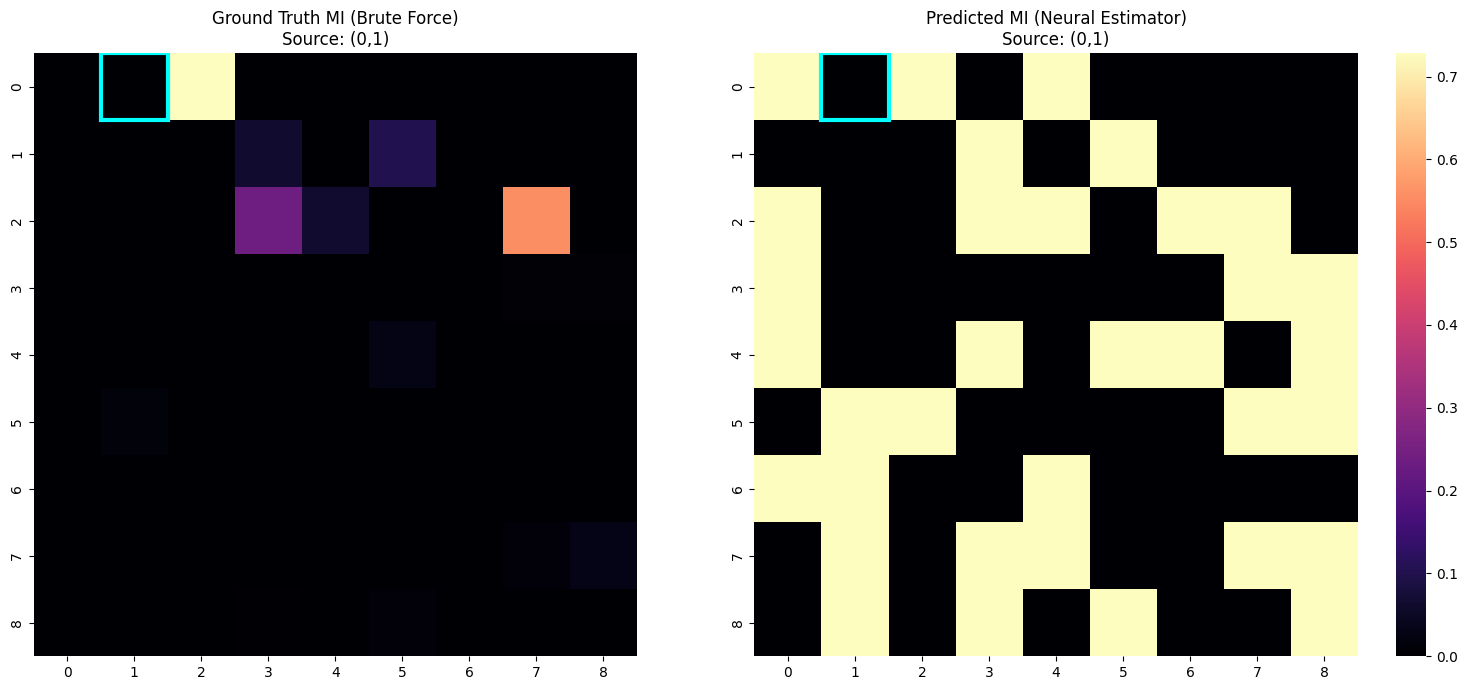

In [ ]:
def visualize_ground_truth_vs_pred(model, ce_predictor, dataset, idx=2005):
    """
    Compares Predicted MI vs Brute-Force Ground Truth MI for a single cell.
    """
    print(f"Generating Ground Truth vs Prediction for puzzle {idx}...")
    model.eval()
    ce_predictor.eval()
    
    # 1. Setup Puzzle
    puzzle, _ = dataset[idx]
    for i in range(puzzle.shape[0]):
        print(str(puzzle[i].item()) + " ", end="")
        if (i + 1) % 9 == 0:
            print("")
    puzzle = puzzle.unsqueeze(0).to(device) # [1, 81]
    
    # Find a good probe cell (an empty one)
    mask = (puzzle == 0)[0]
    empty_indices = mask.nonzero(as_tuple=True)[0]
    if len(empty_indices) == 0: return
    
    # Let's pick a cell near the center if possible, or just the first one
    source_idx = empty_indices[0].item()
    r, c = divmod(source_idx, 9)
    print(f"Inspecting dependencies for Cell ({r}, {c})...")

    # ==========================================
    # A. Get PREDICTED MI
    # ==========================================
    with torch.no_grad():
        emb = model.embedding(puzzle)
        emb = model.pos_encoder(emb)
        features = model.transformer(emb)
        logits = model.fc_out(features)
        probs = F.softmax(logits, dim=-1)
        
        # Base Entropy H(j)
        H_j = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1) # [1, 81]
        
        # Predicted H(j|i)
        pred_H_j_given_i = ce_predictor(features) # [1, 81, 81]
        
        # Predicted MI
        pred_MI_matrix = H_j.unsqueeze(1) - pred_H_j_given_i
        pred_MI_matrix = torch.clamp(pred_MI_matrix, min=0)
        
        # Extract map for source_idx
        pred_map = pred_MI_matrix[0, source_idx].cpu().numpy().reshape(9, 9)

    # ==========================================
    # B. Get GROUND TRUTH MI (Brute Force)
    # ==========================================
    # MI(X_j ; X_i) = H(X_j) - \sum_{x} P(X_i=x) * H(X_j | X_i=x)
    
    # 1. Get P(X_i = x) for the source cell
    p_source = probs[0, source_idx, 1:] # [9]
    # Normalize (in case we want to ignore very low prob tokens, but usually okay)
    
    # 2. Run model for every possible value of X_i
    weighted_conditional_entropy = torch.zeros(81, device=device)
    
    # We only care about top-k probable values to save time, or do all 9
    top_k = 9 
    top_p, top_tokens = torch.topk(p_source, k=top_k)
    top_tokens += 1 # shift 1-9
    
    # Re-normalize weights for the sum
    weights = top_p / top_p.sum()
    
    print("Running brute-force inference...")
    for k in range(top_k):
        token = top_tokens[k]
        w = weights[k]
        
        # Create hypothetical puzzle
        p_hypo = puzzle.clone()
        p_hypo[0, source_idx] = token
        
        with torch.no_grad():
            logits_hypo = model(p_hypo)
            probs_hypo = F.softmax(logits_hypo, dim=-1)
            H_conditional = -torch.sum(probs_hypo * torch.log(probs_hypo + 1e-10), dim=-1) # [1, 81]
            
        weighted_conditional_entropy += w * H_conditional[0]
        
    # GT MI = H(j) - Expected_H(j|i)
    gt_mi_vector = H_j[0] - weighted_conditional_entropy
    gt_mi_vector = torch.clamp(gt_mi_vector, min=0)
    gt_map = gt_mi_vector.cpu().numpy().reshape(9, 9)

    # ==========================================
    # C. Plotting
    # ==========================================

    print("mutual information with this masked index and other masked indices")
    print(gt_map.reshape(-1)[mask.tolist()])
    print("mutual information with this masked index and other unmasked indices")
    print(gt_map.reshape(-1)[(puzzle != 0)[0].tolist()])
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Common scaling for comparison
    vmin = min(gt_map.min(), gt_map.min())
    vmax = max(gt_map.max(), gt_map.max())
    
    # Plot GT
    sns.heatmap(gt_map, ax=axes[0], cmap='magma', square=True, vmin=vmin, vmax=vmax, cbar=False)
    axes[0].set_title(f"Ground Truth MI (Brute Force)\nSource: ({r},{c})")
    axes[0].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    # Plot Pred
    sns.heatmap(pred_map, ax=axes[1], cmap='magma', square=True, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Predicted MI (Neural Estimator)\nSource: ({r},{c})")
    axes[1].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    plt.tight_layout()
    plt.savefig('gt_vs_pred_mi.png')
    plt.show()

# Run comparison
visualize_ground_truth_vs_pred(base_model, ce_predictor, full_dataset)

In [ ]:
print("\n" + "="*50)
print("  STRESS TEST: High Temperature Sampling (T=1.5)")
print("  Goal: Break the baseline by introducing noise.")
print("="*50)

k_values = [8, 16, 32]
# Using T=1.5 to force errors in the baseline
temp = 1.5 

for k in k_values:
    print(f"\n[Step Size k={k}, Temp={temp}]")
    
    # 1. Random
    res_rnd = solve_sampling(base_model, None, empty_puzzles, 'random', k=k, temperature=temp)
    acc_rnd = sum([check_sudoku_valid(p) for p in res_rnd]) / num_eval
    uniq_mi = count_unique(res_rnd)
    print(f"  Random     | Valid: {acc_rnd:.2%} | Unique: {uniq_mi}/{num_eval}")
    
    # 2. MI Guided
    # You might need to tune 'penalty' higher for high temps
    res_mi = solve_sampling(base_model, ce_predictor, empty_puzzles, 'mi', k=k, temperature=temp, penalty=5.0)
    acc_mi = sum([check_sudoku_valid(p) for p in res_mi]) / num_eval
    uniq_mi = count_unique(res_mi)
    print(f"  MI-Guided  | Valid: {acc_mi:.2%} | Unique: {uniq_mi}/{num_eval}")


  STRESS TEST: High Temperature Sampling (T=1.5)
  Goal: Break the baseline by introducing noise.

[Step Size k=8, Temp=1.5]
  Random     | Valid: 100.00%
  MI-Guided  | Valid: 100.00%

[Step Size k=16, Temp=1.5]
  Random     | Valid: 100.00%
  MI-Guided  | Valid: 100.00%

[Step Size k=32, Temp=1.5]
  Random     | Valid: 100.00%
  MI-Guided  | Valid: 100.00%


In [13]:
# ============================================================================
# 9. Real Puzzle Evaluation (Constraint Satisfaction)
# ============================================================================

def evaluate_on_real_puzzles(base_model, ce_predictor, dataset, num_eval=100, start_idx=2000):
    print("\n" + "="*50)
    print("  EVALUATION: Real Partial Puzzles (CSV Data)")
    print("  Goal: Solve 'Quizzes' with fixed constraints.")
    print("="*50)
    
    # 1. Load Data
    # We take puzzles from the dataset that have not been seen during training
    indices = range(start_idx, start_idx + num_eval)
    
    # Dataset returns (puzzle, solution)
    # puzzle has 0s, solution is full
    batch_puzzles = torch.stack([dataset[i][0] for i in indices]).to(device)
    batch_solutions = torch.stack([dataset[i][1] for i in indices]).to(device)
    
    print(f"Loaded {num_eval} puzzles from CSV.")
    print(f"Average clues per puzzle: {(batch_puzzles != 0).float().mean(dim=1).mean().item():.1f}")

    # 2. Run Comparison
    k_values = [4, 8, 16]
    # We use T=1.2 to simulate "uncertainty" in the model
    # If T=1.0 (Argmax), the model might just be too perfect.
    temp = 1.2
    
    for k in k_values:
        print(f"\n[Step Size k={k}, Temp={temp}]")
        
        # --- Random ---
        # We pass the partial puzzles as the starting point
        res_rnd = solve_sampling(
            base_model, None, batch_puzzles, 
            strategy='random', k=k, temperature=temp
        )
        
        # Check against GROUND TRUTH solution (stricter than just validity)
        # Because for a fixed puzzle, there is usually only 1 valid solution.
        correct_rnd = (res_rnd == batch_solutions).all(dim=1).float().mean().item()
        
        # Also check general validity (in case it found an alternative valid solution)
        valid_rnd = sum([check_sudoku_valid(p) for p in res_rnd]) / num_eval
        
        print(f"  Random     | Exact Match: {correct_rnd:.2%} | Valid: {valid_rnd:.2%}")
        
        # --- MI Guided ---
        res_mi = solve_sampling(
            base_model, ce_predictor, batch_puzzles, 
            strategy='mi', k=k, temperature=temp, penalty=3.0
        )
        
        correct_mi = (res_mi == batch_solutions).all(dim=1).float().mean().item()
        valid_mi = sum([check_sudoku_valid(p) for p in res_mi]) / num_eval
        
        print(f"  MI-Guided  | Exact Match: {correct_mi:.2%} | Valid: {valid_mi:.2%}")

# Run it
# Assuming 'full_dataset' is already loaded from previous cells
evaluate_on_real_puzzles(base_model, ce_predictor, full_dataset, num_eval=100)


  EVALUATION: Real Partial Puzzles (CSV Data)
  Goal: Solve 'Quizzes' with fixed constraints.
Loaded 100 puzzles from CSV.
Average clues per puzzle: 0.4

[Step Size k=4, Temp=1.2]
  Random     | Exact Match: 40.00% | Valid: 100.00%
  MI-Guided  | Exact Match: 28.00% | Valid: 100.00%

[Step Size k=8, Temp=1.2]
  Random     | Exact Match: 35.00% | Valid: 100.00%
  MI-Guided  | Exact Match: 34.00% | Valid: 100.00%

[Step Size k=16, Temp=1.2]
  Random     | Exact Match: 34.00% | Valid: 100.00%
  MI-Guided  | Exact Match: 26.00% | Valid: 100.00%


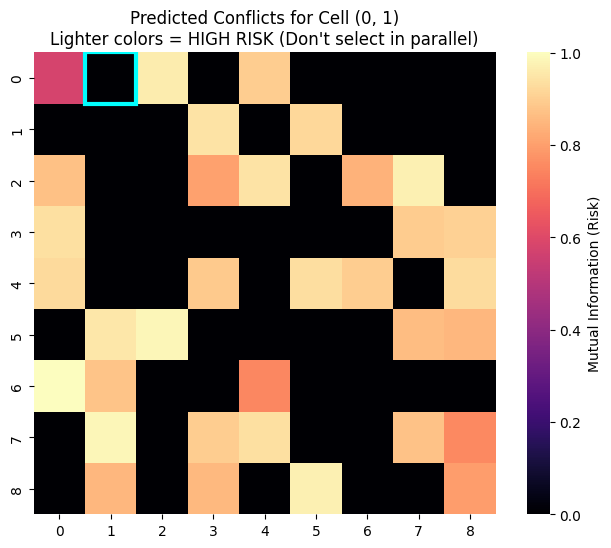

In [14]:
def visualize_mi_structure(model, ce_predictor, dataset, idx=2005):
    """
    Visualizes the Learned MI Matrix for a specific real puzzle.
    """
    import seaborn as sns
    
    model.eval()
    ce_predictor.eval()
    
    # Load one specific hard puzzle
    puzzle, _ = dataset[idx]
    puzzle = puzzle.unsqueeze(0).to(device)
    
    # Get MI Matrix
    with torch.no_grad():
        emb = model.embedding(puzzle)
        emb = model.pos_encoder(emb)
        features = model.transformer(emb)
        logits = model.fc_out(features)
        probs = F.softmax(logits, dim=-1)
        
        H_i = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1) # [1, 81]
        H_j_given_i = ce_predictor(features) # [1, 81, 81]
        
        # MI = H(j) - H(j|i)
        MI = H_i.unsqueeze(1) - H_j_given_i
        MI = torch.clamp(MI, min=0)
        MI = (MI + MI.transpose(1, 2)) / 2
        
    # Plotting
    # We pick an empty cell to be the "Source"
    mask = (puzzle == 0)[0]
    empty_indices = mask.nonzero(as_tuple=True)[0]
    
    if len(empty_indices) == 0:
        print("Puzzle is already full!")
        return

    # Pick the first empty cell as our probe
    source_idx = empty_indices[0].item()
    source_r, source_c = divmod(source_idx, 9)
    
    # Get the MI map for this cell
    mi_map = MI[0, source_idx].cpu().numpy().reshape(9, 9)
    
    # Create Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(mi_map, cmap='magma', square=True, cbar_kws={'label': 'Mutual Information (Risk)'})
    
    # Highlight the source cell
    ax.add_patch(plt.Rectangle((source_c, source_r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    plt.title(f"Predicted Conflicts for Cell ({source_r}, {source_c})\nLighter colors = HIGH RISK (Don't select in parallel)")
    plt.savefig('mi_structure_vis.png')
    plt.show()

# Visualize one
visualize_mi_structure(base_model, ce_predictor, full_dataset)


--- Corrected Ground Truth Analysis for Puzzle 2005 ---
Source Cell: (0, 1)
Base Entropy of Source Cell: 0.0670

[Mutual Information Stats]
  Self-MI (Should match Base Entropy): 0.0000

  MI on Masked Neighbors:
    Neighbor (0,6): Avg=0.00022 | MaxImpact=0.00037
    Neighbor (2,2): Avg=0.00041 | MaxImpact=0.00048


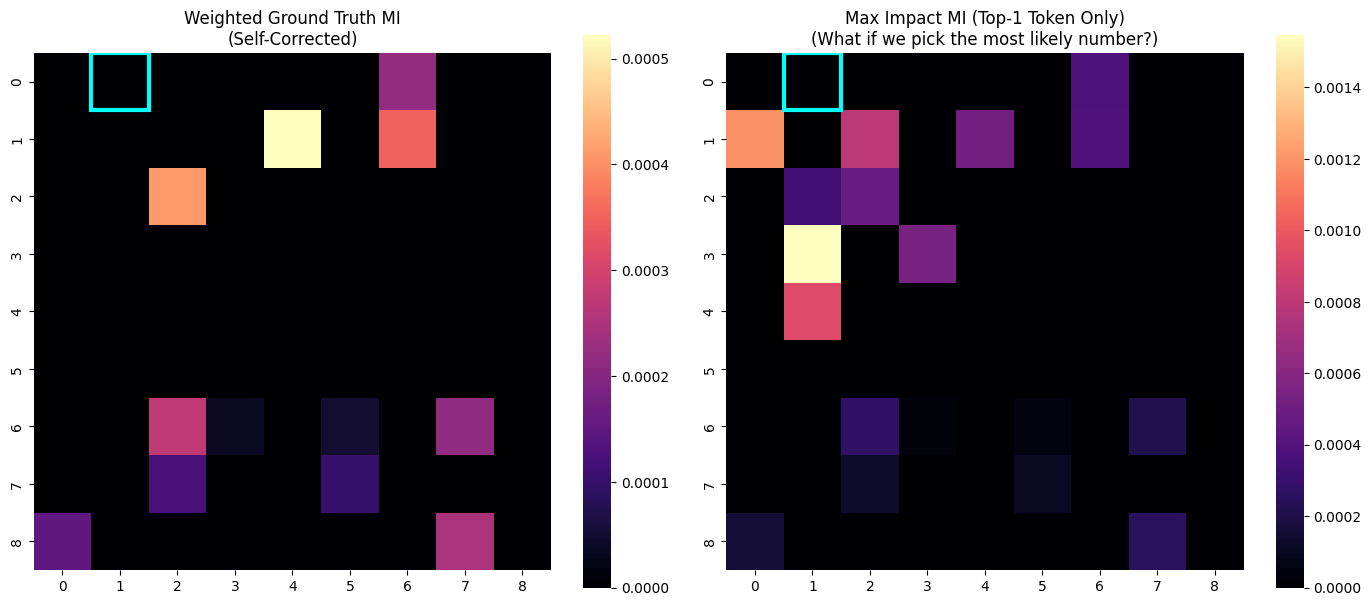

In [60]:
def visualize_ground_truth_corrected(model, ce_predictor, dataset, idx=2005):
    print(f"\n--- Corrected Ground Truth Analysis for Puzzle {idx} ---")
    model.eval()
    ce_predictor.eval()
    
    # 1. Setup
    puzzle, _ = dataset[idx]
    puzzle = puzzle.unsqueeze(0).to(device)
    
    mask = (puzzle == 0)[0]
    if mask.sum() == 0: return
    # Pick the first empty cell
    source_idx = mask.nonzero(as_tuple=True)[0][0].item()
    r, c = divmod(source_idx, 9)
    print(f"Source Cell: ({r}, {c})")
    
    # 2. Compute Base Entropy H(j)
    with torch.no_grad():
        logits = model(puzzle)
        probs = F.softmax(logits, dim=-1)
        # Base Entropy
        H_j = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)[0]
        
        print(f"Base Entropy of Source Cell: {H_j[source_idx].item():.4f}")

        # 3. Brute Force Conditional Entropy
        p_source = probs[0, source_idx, 1:] # [9]
        top_p, top_tokens = torch.topk(p_source, k=9)
        top_tokens += 1
        weights = top_p / top_p.sum()
        
        weighted_H_cond = torch.zeros(81, device=device)
        
        # Track the 'Best Case' (Most likely token) to see maximum impact
        best_token_impact = None
        
        for k in range(9):
            token = top_tokens[k]
            w = weights[k]
            
            p_hypo = puzzle.clone()
            p_hypo[0, source_idx] = token
            
            # Run inference
            probs_hypo = F.softmax(model(p_hypo), dim=-1)
            H_cond = -torch.sum(probs_hypo * torch.log(probs_hypo + 1e-10), dim=-1)[0]
            
            # --- FIX 1: FORCE SELF-ENTROPY TO 0 ---
            # The model output at source_idx is garbage, but WE know it's fixed.
            H_cond[source_idx] = 0.0
            
            weighted_H_cond += w * H_cond
            
            if k == 0: # Most likely token
                best_token_impact = H_j - H_cond
                best_token_impact[source_idx] = 0#H_j[source_idx] # Self MI
                best_token_impact[~mask] = 0 # Ignore unmasked garbage
        
        # 4. Calculate MI
        GT_MI = H_j - weighted_H_cond
        
        # --- FIX 2: Clamp and Clean ---
        GT_MI = torch.clamp(GT_MI, min=0)
        GT_MI[~mask] = 0.0 # Zero out non-masked cells
        
        # Force Self-MI explicitly to be safe (Formula should handle it now, but good to be sure)
        # H(i) - 0 = H(i)
        GT_MI[source_idx] = 0#H_j[source_idx]

    # 5. Stats
    print("\n[Mutual Information Stats]")
    print(f"  Self-MI (Should match Base Entropy): {GT_MI[source_idx].item():.4f}")
    
    # Check Neighbors
    row_indices = [r * 9 + x for x in range(9) if x != c]
    col_indices = [x * 9 + c for x in range(9) if x != r]
    box_r, box_c = (r // 3) * 3, (c // 3) * 3
    box_indices = [(box_r + x)*9 + (box_c + y) for x in range(3) for y in range(3)]
    neighbors = set(row_indices + col_indices + box_indices) - {source_idx}
    
    print("\n  MI on Masked Neighbors:")
    for n_idx in neighbors:
        if mask[n_idx]:
            val = GT_MI[n_idx].item()
            best_val = best_token_impact[n_idx].item()
            if val > 1e-4:
                nr, nc = divmod(n_idx, 9)
                print(f"    Neighbor ({nr},{nc}): Avg={val:.5f} | MaxImpact={best_val:.5f}")

    # 6. Plot Side-by-Side
    
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(GT_MI.cpu().numpy().reshape(9, 9), ax=axes[0], cmap='magma', square=True)
    axes[0].set_title(f"Weighted Ground Truth MI\n(Self-Corrected)")
    axes[0].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    best_token_impact = torch.clamp(best_token_impact, min=0)
    sns.heatmap(best_token_impact.cpu().numpy().reshape(9, 9), ax=axes[1], cmap='magma', square=True)
    axes[1].set_title(f"Max Impact MI (Top-1 Token Only)\n(What if we pick the most likely number?)")
    axes[1].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    plt.tight_layout()
    plt.show()

visualize_ground_truth_corrected(base_model, ce_predictor, full_dataset)


--- Corrected Ground Truth Analysis for Puzzle 2005 (Top-1 Impact) ---
Source Cell: (0, 1)
Base Entropy of Source Cell: 0.0670


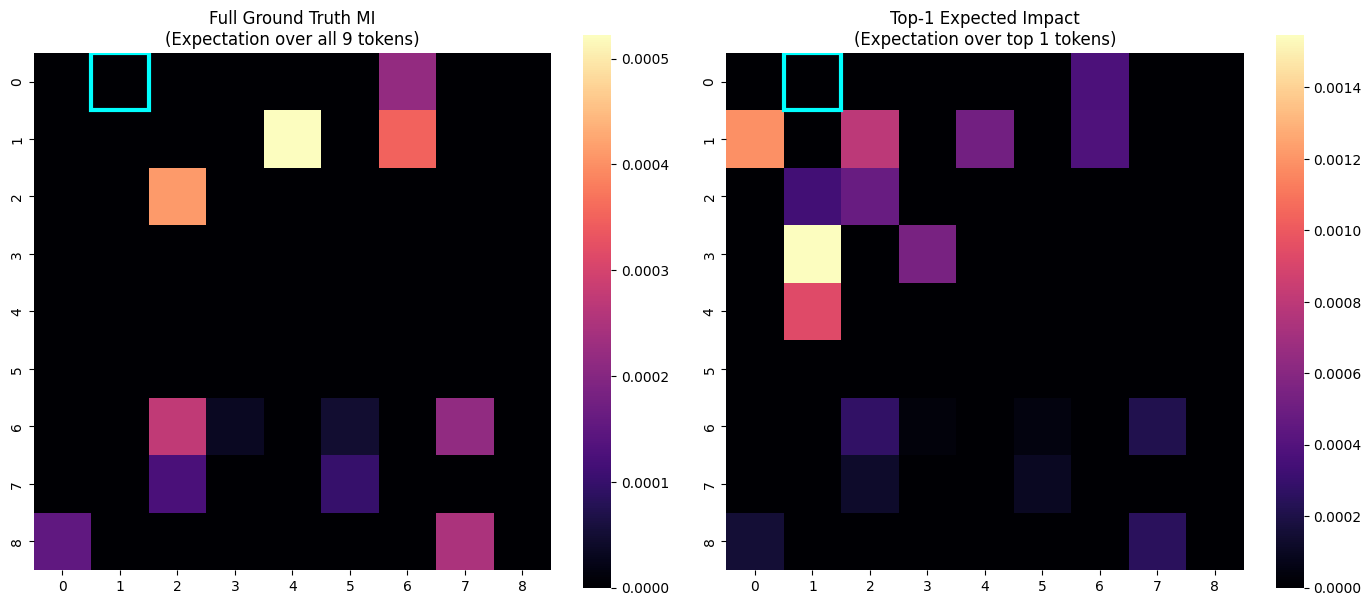

In [61]:
def visualize_ground_truth_corrected(model, ce_predictor, dataset, idx=2005, top_k_viz=1):
    print(f"\n--- Corrected Ground Truth Analysis for Puzzle {idx} (Top-{top_k_viz} Impact) ---")
    model.eval()
    ce_predictor.eval()
    
    # 1. Setup
    puzzle, _ = dataset[idx]
    puzzle = puzzle.unsqueeze(0).to(device)
    
    mask = (puzzle == 0)[0]
    if mask.sum() == 0: return
    # Pick the first empty cell
    source_idx = mask.nonzero(as_tuple=True)[0][0].item()
    r, c = divmod(source_idx, 9)
    print(f"Source Cell: ({r}, {c})")
    
    # 2. Compute Base Entropy H(j)
    with torch.no_grad():
        logits = model(puzzle)
        probs = F.softmax(logits, dim=-1)
        # Base Entropy
        H_j = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)[0]
        
        print(f"Base Entropy of Source Cell: {H_j[source_idx].item():.4f}")

        # 3. Brute Force Conditional Entropy
        p_source = probs[0, source_idx, 1:] # [9]
        top_p, top_tokens = torch.topk(p_source, k=9)
        top_tokens += 1
        
        # We need weights for the Full GT (all 9) and the Top-K GT (subset)
        weights_full = top_p / top_p.sum()
        
        # For Top-K, we re-normalize the weights of just the top k tokens
        top_k_p = top_p[:top_k_viz]
        weights_top_k = top_k_p / top_k_p.sum()
        
        weighted_H_cond_full = torch.zeros(81, device=device)
        weighted_H_cond_top_k = torch.zeros(81, device=device)
        
        for k in range(9):
            token = top_tokens[k]
            
            p_hypo = puzzle.clone()
            p_hypo[0, source_idx] = token
            
            # Run inference
            probs_hypo = F.softmax(model(p_hypo), dim=-1)
            H_cond = -torch.sum(probs_hypo * torch.log(probs_hypo + 1e-10), dim=-1)[0]
            
            # --- FIX: FORCE SELF-ENTROPY TO 0 ---
            H_cond[source_idx] = 0.0
            
            # Accumulate Full GT
            weighted_H_cond_full += weights_full[k] * H_cond
            
            # Accumulate Top-K GT (Only if within top k)
            if k < top_k_viz:
                weighted_H_cond_top_k += weights_top_k[k] * H_cond
        
        # 4. Calculate MI
        GT_MI_Full = H_j - weighted_H_cond_full
        GT_MI_TopK = H_j - weighted_H_cond_top_k
        
        # --- FIX: Clean up ---
        # Zero out unmasked (garbage) and clamp
        for tensor in [GT_MI_Full, GT_MI_TopK]:
            tensor.clamp_(min=0)
            tensor[~mask] = 0.0
            tensor[source_idx] = 0.0 # Clear self for visualization clarity
            
    # 5. Plot Side-by-Side 
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Full GT
    sns.heatmap(GT_MI_Full.cpu().numpy().reshape(9, 9), ax=axes[0], cmap='magma', square=True)
    axes[0].set_title(f"Full Ground Truth MI\n(Expectation over all 9 tokens)")
    axes[0].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    # Plot Top-K Impact
    sns.heatmap(GT_MI_TopK.cpu().numpy().reshape(9, 9), ax=axes[1], cmap='magma', square=True)
    axes[1].set_title(f"Top-{top_k_viz} Expected Impact\n(Expectation over top {top_k_viz} tokens)")
    axes[1].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    
    plt.tight_layout()
    plt.show()

# Run with Top-3 to smooth out the noise from Top-1 but keep it sharper than Full
visualize_ground_truth_corrected(base_model, ce_predictor, full_dataset, top_k_viz=1)